<a href="https://colab.research.google.com/github/ElingP/bcc_internship_2020_ds/blob/master/knn_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

===Original data===
   sepallength  sepalwidth  petallength  petalwidth        class
0          5.1         3.5          1.4         0.2  Iris-setosa
1          4.9         3.0          1.4         0.2  Iris-setosa
2          4.7         3.2          1.3         0.2  Iris-setosa
3          4.6         3.1          1.5         0.2  Iris-setosa
4          5.0         3.6          1.4         0.2  Iris-setosa
5          5.4         3.9          1.7         0.4  Iris-setosa
6          4.6         3.4          1.4         0.3  Iris-setosa
7          5.0         3.4          1.5         0.2  Iris-setosa
8          4.4         2.9          1.4         0.2  Iris-setosa
9          4.9         3.1          1.5         0.1  Iris-setosa
Shape	:  (150, 5)


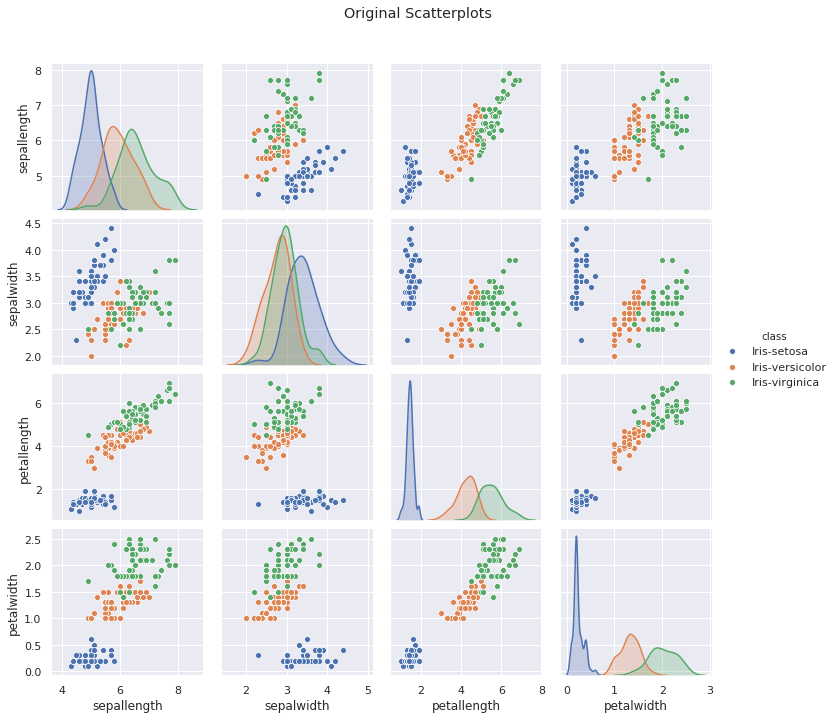

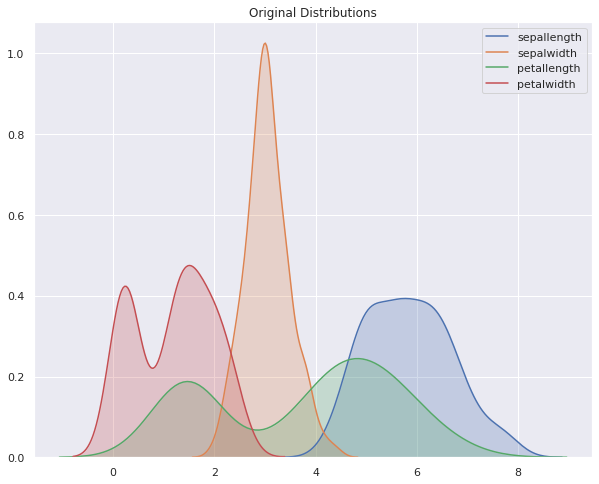


===Preprocessed data===
   sepallength  sepalwidth  petallength  petalwidth        class
0     0.222222    0.625000     0.067797    0.041667  Iris-setosa
1     0.166667    0.416667     0.067797    0.041667  Iris-setosa
2     0.111111    0.500000     0.050847    0.041667  Iris-setosa
3     0.083333    0.458333     0.084746    0.041667  Iris-setosa
4     0.194444    0.666667     0.067797    0.041667  Iris-setosa
5     0.305556    0.791667     0.118644    0.125000  Iris-setosa
6     0.083333    0.583333     0.067797    0.083333  Iris-setosa
7     0.194444    0.583333     0.084746    0.041667  Iris-setosa
8     0.027778    0.375000     0.067797    0.041667  Iris-setosa
9     0.166667    0.458333     0.084746    0.000000  Iris-setosa
Shape	:  (150, 5)


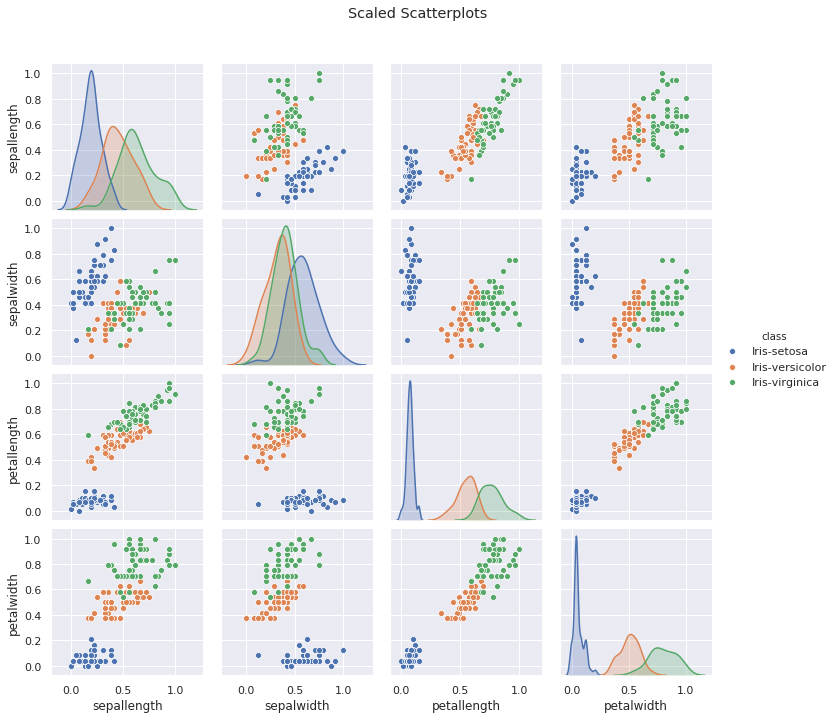

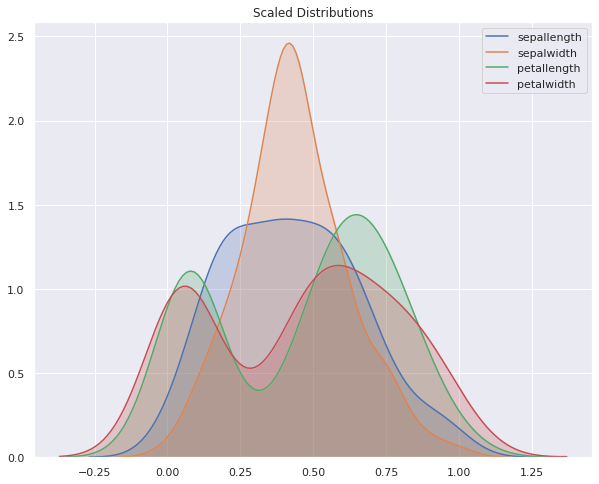


===Using our model===
Score (k = 11)	: 0.96667


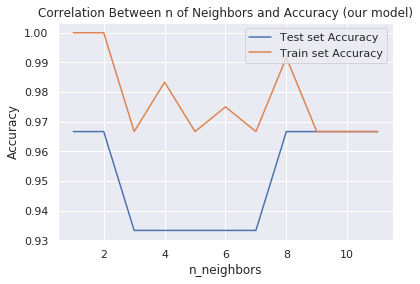


===Using scikit===
Score (k = 11)	: 0.96667


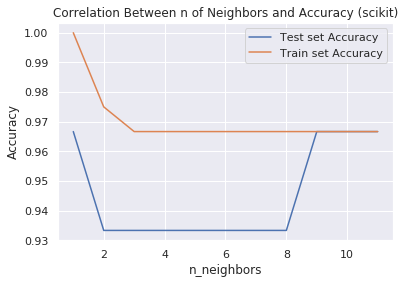


===Using KFold Cross Validation===


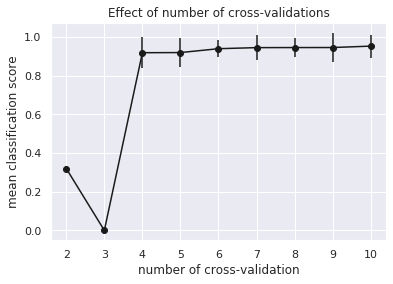

For KNN using n_neighbors =  3
and k_fold =  10
Model: KNearestNeighbors (our model), Acuracy: 0.93333 (+/- 0.16865)
Model: KNeighborsClassifier (scikit), Acuracy: 0.93333 (+/- 0.16865)


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
from operator import itemgetter

plt.style.use("ggplot")
sns.set()


class KNearestNeighbors(object):

    X_train, y_train = None, None
    n_neighbors = 5

    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    # Calculate the Euclidean distance between two data
    def _euclidean_distance(self, data1, data2):
        distance = 0
        for i in range(len(data1)):
            distance += np.square(data1[i] - data2[i])
        return np.sqrt(distance)

    # Fit the train set into the object
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # Predict the target with its features
    def predict(self, X):
        y_pred = []

        for i in range(len(X)):

            distances = {}

            # Calculating Euclidean distance between each row of training data and test data
            for j in range(len(self.X_train)):
                dist = self._euclidean_distance(X[i], self.X_train[j])
                distances[j] = dist

            # Sorting them based on distance
            sorted_distances = sorted(distances.items(), key=itemgetter(1))

            neighbors = []

            # Finding top k neighbors
            for j in range(self.n_neighbors):
                neighbors.append(sorted_distances[j][0])

            class_votes = {}

            # Voting the most frequent clwass in the neighbors
            for j in range(len(neighbors)):
                response = self.y_train[neighbors[j]]

                if response in class_votes:
                    class_votes[response] += 1
                else:
                    class_votes[response] = 1

            sorted_votes = sorted(class_votes.items(), key=itemgetter(1), reverse=True)
            y_pred.append(sorted_votes[0][0])

        return np.array(y_pred)

    # Calculate the accuracy of the model
    def score(self, X, y):
        return np.mean(y == self.predict(X))

    # Iterate n_neighbors to find all scores and the best n_neighbors
    def iterate_neighbors(self, X_test, y_test, max_k=10):
        neighbors = np.arange(1, max_k)
        train_accuracy = np.empty(len(neighbors))
        test_accuracy = np.empty(len(neighbors))
        best_k, best_accuracy = 0, 0

        # Loop over n_neighbors values
        for i in range(len(neighbors)):
            self.n_neighbors = neighbors[i]
            train_accuracy[i] = self.score(self.X_train, self.y_train)
            test_accuracy[i] = self.score(X_test, y_test)
            if test_accuracy[i] >= best_accuracy:
                best_accuracy = test_accuracy[i]
                best_k = neighbors[i]

        return neighbors, train_accuracy, test_accuracy, best_k

    def iterate_neighbors_v2(self, X, y, max_k=10, random_state=None):
        neighbors = np.arange(1, max_k)
        accuracy = np.empty(len(neighbors))
        best_k, best_accuracy = 0, 0

        # Loop over n_neighbors values
        for i in range(len(neighbors)):
            self.n_neighbors = neighbors[i]
            score = ModelSelection().cross_val_score(self, X, y, random_state=42)
            accuracy[i] = np.mean(score)
            if accuracy[i] >= best_accuracy:
                best_accuracy = accuracy[i]
                best_k = neighbors[i]

        return neighbors, accuracy, best_k

    # Generate plot to visualize train and test data
    def generate_neighbors_plot(self, neighbors, train_accuracy, test_accuracy):
        plt.plot(neighbors, test_accuracy, label="Test set Accuracy")
        plt.plot(neighbors, train_accuracy, label="Train set Accuracy")
        plt.legend(loc="best")
        plt.xlabel("n_neighbors")
        plt.ylabel("Accuracy")
        plt.title("Correlation Between n of Neighbors and Accuracy (our model)")
        plt.show()


class ModelSelection(object):

    # Split dataset into a train and test set
    def train_test_split(self, X, y, train_size=0.75, random_state=None):
        np.random.seed(random_state)
        indices = np.random.permutation(X.shape[0])
        length = int(len(X) * train_size)
        training_idx, test_idx = indices[:length], indices[length:]
        X_train, X_test, y_train, y_test = (
            X[training_idx, :],
            X[test_idx, :],
            y[training_idx],
            y[test_idx],
        )
        return X_train, X_test, y_train, y_test

    # Split dataset into k fold
    # This is the implementation of the 2nd answer from :
    # https://stackoverflow.com/questions/43442072/pandas-how-can-i-do-cross-validation-without-using-scikit
    def k_fold(self, X, y, n_splits=5):
        X = np.array_split(X, n_splits)
        y = np.array_split(y, n_splits)
        return np.asarray(X), np.asarray(y)

    # Get the score of the estimator
    def cross_validate(self, estimator, X, y, X_test, y_test):
        estimator.fit(X, y)
        return estimator.score(X_test, y_test)

    # Cross validate using k fold method
    def cross_val_score(self, estimator, X, y, scoring=None, cv=5, random_state=None):
        folds_X, folds_y = self.k_fold(X=X, y=y, n_splits=cv)
        score = []
        for i in range(cv):
            X_train = folds_X.copy()  # you wanna work on a copy of your array
            y_train = folds_y.copy()
            X_test = folds_X[i]
            y_test = folds_y[i]
            X_train = np.delete(X_train, i, 0)
            y_train = np.delete(y_train, i, 0)
            X_train = np.concatenate(X_train)
            y_train = np.concatenate(y_train)
            score.append(
                self.cross_validate(
                    estimator,
                    X_train.copy(),
                    y_train.copy(),
                    X_test.copy(),
                    y_test.copy(),
                )
            )
        return score


class Preprocessing(object):

    # Impute missing values with either mean, median, most_frequent, constant, or drop the entire row
    def impute(self, data, missing_values=np.nan, strategy="mean", fill_value=None):
        if missing_values != np.nan:
            data.iloc[:, :-1] = data.iloc[:, :-1].replace(missing_values, np.nan)
        if strategy == "mean":
            data.fillna(data.mean(), inplace=True)
        elif strategy == "median":
            data.fillna(data.median(), inplace=True)
        elif strategy == "most_frequent":
            data.fillna(data.mode(), inplace=True)
        elif strategy == "constant":
            data.fillna(fill_value, inplace=True)
        elif strategy == "drop":
            data.dropna(inplace=True)
        return data

    # Transform features by scaling each feature to a given range
    def min_max_scale(self, X, feature_range=(0, 1)):
        data_min = np.nanmin(X, axis=0)
        data_max = np.nanmax(X, axis=0)
        data_range = data_max - data_min
        scale = (feature_range[1] - feature_range[0]) / data_range
        min = feature_range[0] - data_min * scale
        X *= scale
        X += min
        return X

    # Standardize features by removing the mean and scaling to unit variance
    def standard_scale(self, X):
        X = np.asarray(X)
        mean = np.nanmean(X)
        scale = np.nanstd(X)

        # Xr is a view on the original array that enables easy use of
        # broadcasting on the axis in which we are interested in
        Xr = np.rollaxis(X, axis=0)

        Xr -= mean
        mean_1 = np.nanmean(Xr, axis=0)
        # Verify that mean_1 is 'close to zero'. If X contains very
        # large values, mean_1 can also be very large, due to a lack of
        # precision of mean_. In this case, a pre-scaling of the
        # concerned feature is efficient, for instance by its mean or
        # maximum.
        if not np.allclose(mean_1, 0):
            warnings.warn(
                "Numerical issues were encountered "
                "when centering the data "
                "and might not be solved. Dataset may "
                "contain too large values. You may need "
                "to prescale your features."
            )
            Xr -= mean_1

        Xr /= scale
        mean_2 = np.nanmean(Xr, axis=0)
        # If mean_2 is not 'close to zero', it comes from the fact that
        # scale_ is very small so that mean_2 = mean_1/scale_ > 0, even
        # if mean_1 was close to zero. The problem is thus essentially
        # due to the lack of precision of mean_. A solution is then to
        # subtract the mean again:
        if not np.allclose(mean_2, 0):
            warnings.warn(
                "Numerical issues were encountered "
                "when scaling the data "
                "and might not be solved. The standard "
                "deviation of the data is probably "
                "very close to 0. "
            )
            Xr -= mean_2

        return X

    # Scale features using statistics that are robust to outliers
    def robust_scale(self, X, quantile_range=(25.0, 75.0)):
        q_min, q_max = quantile_range
        center = np.nanmedian(X, axis=0)
        quantiles = []
        for feature_idx in range(X.shape[1]):
            column_data = X.iloc[:, feature_idx]
            quantiles.append(np.nanpercentile(column_data, quantile_range))

        quantiles = np.transpose(quantiles)

        scale = quantiles[1] - quantiles[0]

        X -= center
        X /= scale
        return X


########################################################

print("===Original data===")

# Importing data
url = "https://datahub.io/machine-learning/iris/r/iris.csv"
# url = 'https://datahub.io/machine-learning/ionosphere/r/ionosphere.csv' # data = data.drop(columns='a02')
# url = 'https://datahub.io/machine-learning/diabetes/r/diabetes.csv'
# url = 'https://datahub.io/machine-learning/sonar/r/sonar.csv'
# url = 'https://datahub.io/machine-learning/blood-transfusion-service-center/r/blood-transfusion-service-center.csv'
# url = 'https://datahub.io/machine-learning/glass/r/glass.csv'
# url = 'https://datahub.io/machine-learning/breast-w/r/breast-w.csv'
# url = 'https://datahub.io/machine-learning/banknote-authentication/r/banknote-authentication.csv'
# url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv' # header = None
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv' # sep = ';'
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv' # sep = ';'

data = pd.read_csv(url)

print(data.head(10))
print("Shape\t: ", data.shape)

sns.pairplot(data=data, hue="class")
plt.subplots_adjust(top=0.9)
plt.suptitle("Original Scatterplots")
plt.show()

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title("Original Distributions")

for col in data.iloc[:, :-1].columns:
    sns.kdeplot(data[col], ax=ax1, shade=True)

plt.show()


########################################################


print("\n===Preprocessed data===")

# Preproceessing data by removing or replacing missing value
data = Preprocessing().impute(data, missing_values=0, strategy="mean")

# Get dummies if feature are categorical, refer to https://towardsdatascience.com/encoding-categorical-features-21a2651a065c
# data.iloc[:, :-1] = pd.get_dummies(data.iloc[:, :-1], prefix_sep='_', drop_first=True)

# Scaling the features data
data.iloc[:, :-1] = Preprocessing().min_max_scale(data.iloc[:, :-1])
# data.iloc[:, :-1] = Preprocessing().standard_scale(data.iloc[:, :-1])
# data.iloc[:, :-1] = Preprocessing().robust_scale(data.iloc[:, :-1])

print(data.head(10))
print("Shape\t: ", data.shape)

# Splitting data into features (X) and target (y)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

sns.pairplot(data=data, hue="class")
plt.subplots_adjust(top=0.9)
plt.suptitle("Scaled Scatterplots")
plt.show()

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title("Scaled Distributions")

for col in data.iloc[:, :-1].columns:
    sns.kdeplot(data[col], ax=ax1, shade=True)

plt.show()


########################################################


print("\n===Using our model===")

# Splitting the data into 80% train and 20% test set with a random seed of 42
X_train, X_test, y_train, y_test = ModelSelection().train_test_split(
    X, y, train_size=0.8, random_state=42
)

# Fitting and printing the score of KNN
knn = KNearestNeighbors()
knn.fit(X_train, y_train)

# Getting the accuracy score for k in 0 < k < sqrt(num of rows)
neighbors, train_accuracy, test_accuracy, best_k = knn.iterate_neighbors(
    X_test, y_test, max_k=int(np.sqrt(X.shape[0]))
)

# Printing the score of KNN with best n_neighbors
knn.n_neighbors = best_k
print("Score (k = %d)\t: %.5f" % (knn.n_neighbors, knn.score(X_test, y_test)))

# Generating plot to view where is the best k for accuracy with x axis being "n_neighbors"
knn.generate_neighbors_plot(neighbors, train_accuracy, test_accuracy)


########################################################


print("\n===Using scikit===")

from sklearn.neighbors import KNeighborsClassifier

neighbors = np.arange(1, int(np.sqrt(X.shape[0])))
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
best_k, best_accuracy = 0, 0

# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Compute traning and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
    if test_accuracy[i] >= best_accuracy:
        best_accuracy = test_accuracy[i]
        best_k = neighbors[i]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
print("Score (k = %d)\t: %.5f" % (best_k, knn.score(X_test, y_test)))

# Generate plot
plt.plot(neighbors, test_accuracy, label="Test set Accuracy")
plt.plot(neighbors, train_accuracy, label="Train set Accuracy")

plt.legend(loc="best")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.title("Correlation Between n of Neighbors and Accuracy (scikit)")
plt.show()


########################################################


print("\n===Using KFold Cross Validation===")

# Getting the accuracy score for k in 0 < k < sqrt(num of rows)
neighbors2, accuracy2, best_k2 = KNearestNeighbors().iterate_neighbors_v2(
    X, y, max_k=int(np.sqrt(X.shape[0]))
)

# The effect of number of cross-validations
cvs = [i for i in range(2, 11)]
cv_scores_means = []
cv_scores_std = []
best_k_fold, best_accuracy = 0, 0
for cv in cvs:
    scores = ModelSelection().cross_val_score(
        KNearestNeighbors(), X, y, cv=cv, random_state=42
    )
    cv_scores_means.append(np.mean(scores))
    cv_scores_std.append(np.std(scores))
    if np.mean(scores) >= best_accuracy:
        best_accuracy = np.mean(scores)
        best_k_fold = cv

plt.errorbar(cvs, cv_scores_means, yerr=cv_scores_std, fmt="k-o")
plt.title("Effect of number of cross-validations")
plt.xlabel("number of cross-validation")
plt.ylabel("mean classification score")
plt.show()

# Comparing models with cross validation
print("For KNN using n_neighbors = ", best_k2)
print("and k_fold = ", best_k_fold)
models = []
models.append(("KNearestNeighbors (our model)", KNearestNeighbors(n_neighbors=best_k2)))
models.append(
    ("KNeighborsClassifier (scikit)", KNeighborsClassifier(n_neighbors=best_k2))
)
for name, model in models:
    score = ModelSelection().cross_val_score(
        model, X, y, cv=best_k_fold, random_state=42
    )
    print(
        "Model: {0}, Acuracy: {1:.5f} (+/- {2:.5f})".format(
            name, np.mean(score), np.std(score) * 2
        )
    )